## tensorflowd的gpu版本支持的python版本是3.6-3.9      
 ---2023.10.29

## keras获取mnist数据集

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import os

# 下载MNIST数据集
# 现在，x_train 和 x_test 包含图像数据，y_train 和 y_test 包含标签。
download_path = os.path.join(os.getcwd(), 'keras_mnist_datasets')
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(path=download_path)

11490434/11490434 [==============================] - 322s 28us/step


(28, 28)


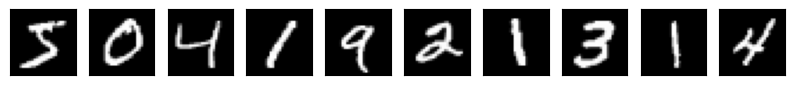

In [2]:
import matplotlib.pyplot as plt
# 检查数据
print(X_train[0].shape)

# 可视化
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

## 构建网络：基于全连接层

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

inputs  = Input(shape=(784,))              # 28*28 flatten
enc_fc  = Dense( 32, activation='relu')    # compress using 32 neurons
encoded = enc_fc(inputs)
dec_fc  = Dense(784, activation='sigmoid') # decompress to 784 pixels
decoded = dec_fc(encoded) 
# build the model to train
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 训练

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess(x):
    x = x.astype('float32') / 255.
    return x.reshape(-1, np.prod(x.shape[1:])) # flatten

X_train = preprocess(X_train)
X_test  = preprocess(X_test)

epochs=10
# also create a validation set for training
X_train, X_valid = train_test_split(X_train, test_size=500)

autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/10
465/465 [==============================] - 2s 3ms/step - loss: 0.2278 - val_loss: 0.1589
Epoch 2/10
465/465 [==============================] - 1s 2ms/step - loss: 0.1429 - val_loss: 0.1269
Epoch 3/10
465/465 [==============================] - 1s 2ms/step - loss: 0.1205 - val_loss: 0.1117
Epoch 4/10
465/465 [==============================] - 1s 2ms/step - loss: 0.1091 - val_loss: 0.1033
Epoch 5/10
465/465 [==============================] - 1s 2ms/step - loss: 0.1025 - val_loss: 0.0981
Epoch 6/10
465/465 [==============================] - 1s 2ms/step - loss: 0.0983 - val_loss: 0.0951
Epoch 7/10
465/465 [==============================] - 1s 2ms/step - loss: 0.0962 - val_loss: 0.0936
Epoch 8/10
465/465 [==============================] - 1s 2ms/step - loss: 0.0953 - val_loss: 0.0929
Epoch 9/10
465/465 [==============================] - 1s 2ms/step - loss: 0.0947 - val_loss: 0.0925
Epoch 10/10
465/465 [==============================] - 1s 2ms/step - loss: 0.0943 - val_loss: 0.0921

313/313 [==============================] - 0s 691us/step


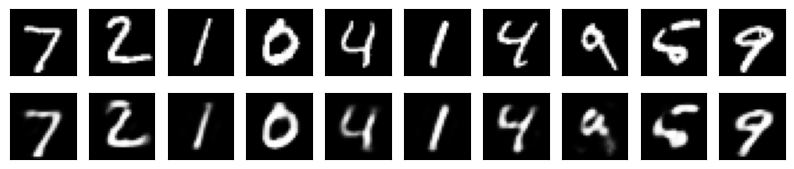

In [5]:
# 测试效果
encoder = Model(inputs, encoded)
X_test_encoded = encoder.predict(X_test)

decoder_inputs = Input(shape=(32,))
decoder = Model(decoder_inputs, dec_fc(decoder_inputs))
X_test_decoded = decoder.predict(X_test_encoded)

# outputs=autoencoder.predict(X_test)
# print(outputs==x_test_decoded)

def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
show_images(X_test, X_test_decoded)

## 卷积神经网络构建autoencoder

In [6]:
def make_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling2D(padding='same')(x)    
    
    # decoding
    x = Conv2D( 8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling2D()(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = Conv2D(16, 3, activation='relu')(x) # <= padding='valid'!
    x = UpSampling2D()(x)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)    
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

autoencoder = make_convolutional_autoencoder()
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584 

In [7]:
# 训练
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

if tf.test.is_gpu_available():
    autoencoder = tf.keras.utils.multi_gpu_model(autoencoder, gpus=1)  # 如果有多个 GPU，可以使用多 GPU 模型

autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=128, validation_data=(X_valid, X_valid))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Epoch 1/10
465/465 [==============================] - 23s 45ms/step - loss: 0.2348 - val_loss: 0.1489
Epoch 2/10
465/465 [==============================] - 21s 44ms/step - loss: 0.1392 - val_loss: 0.1266
Epoch 3/10
465/465 [==============================] - 21s 44ms/step - loss: 0.1241 - val_loss: 0.1173
Epoch 4/10
465/465 [==============================] - 21s 44ms/step - loss: 0.1163 - val_loss: 0.1114
Epoch 5/10
465/465 [==============================] - 21s 44ms/step - loss: 0.1119 - val_loss: 0.1079
Epoch 6/10
465/465 [==============================] - 21s 44ms/step - loss: 0.1091 - val_loss: 0.1055
Epoch 7/10
465/465 [==============================] - 21s 44ms/step - loss: 0.1069 - val_loss: 0.1035
Epoch 8/10
465/465 [==============================] - 21s 44ms/step - loss: 0.1051 - val_loss: 0.1018
Epoch 9/10
465/465 [==============================] - 21s 44ms/step - loss: 0.1034 - val_loss: 0.1003
E

313/313 [==============================] - 1s 4ms/step


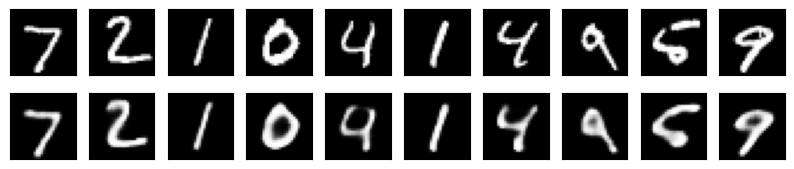

In [8]:
X_test_decoded = autoencoder.predict(X_test)
show_images(X_test, X_test_decoded)

## 卷积autoencoder 降噪

In [11]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
X_train_noisy = add_noise(X_train)
X_valid_noisy = add_noise(X_valid)
X_test_noisy  = add_noise(X_test)

autoencoder = make_convolutional_autoencoder()
autoencoder.fit(X_train_noisy, X_train, epochs=epochs, batch_size=128, validation_data=(X_valid_noisy, X_valid))

Epoch 1/10
465/465 [==============================] - 23s 48ms/step - loss: 0.2345 - val_loss: 0.1581
Epoch 2/10
465/465 [==============================] - 21s 46ms/step - loss: 0.1504 - val_loss: 0.1390
Epoch 3/10
465/465 [==============================] - 21s 46ms/step - loss: 0.1376 - val_loss: 0.1301
Epoch 4/10
465/465 [==============================] - 21s 45ms/step - loss: 0.1310 - val_loss: 0.1250
Epoch 5/10
465/465 [==============================] - 23s 50ms/step - loss: 0.1266 - val_loss: 0.1219
Epoch 6/10
465/465 [==============================] - 26s 56ms/step - loss: 0.1234 - val_loss: 0.1195
Epoch 7/10
465/465 [==============================] - 26s 56ms/step - loss: 0.1210 - val_loss: 0.1173
Epoch 8/10
465/465 [==============================] - 26s 57ms/step - loss: 0.1190 - val_loss: 0.1152
Epoch 9/10
465/465 [==============================] - 27s 57ms/step - loss: 0.1174 - val_loss: 0.1140
Epoch 10/10
465/465 [==============================] - 26s 56ms/step - loss: 0.115

313/313 [==============================] - 1s 4ms/step


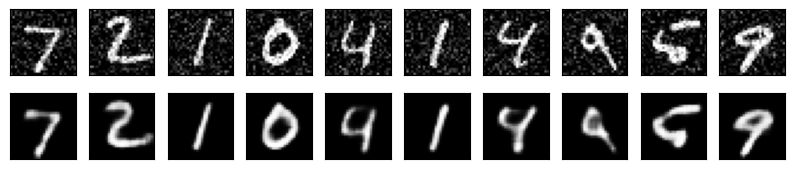

In [13]:
X_test_decoded = autoencoder.predict(X_test_noisy)
show_images(X_test_noisy, X_test_decoded)